## Equações de Bellman dos jogadores para o modelo de Dou et al (2019)

In [1]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numba as nb
from numba import jit, njit, jitclass, prange, float64, int32
%matplotlib inline


import time

### Parâmetros do jogo

In [43]:
μ = 4.566 #número de meses entre períodos, traduz a quantidade de períodos t em quantidade de meses
# ρ = 0.884 # (1 - ρ) é a taxa de depreciação da empresa a cada período
ρ = 0.5 #testando nova taxa de depreciação
β = 9.84 #usamos aqui a distribuição Uniforme, depois vamos mudar isto
c0 = 0.044 #custo fixo de ir para a corte
c1 = 0.015 #custo variável de ir para a corte


hs0 = 0.28 #habilidade inicial de s
hj0 = 0.36 #habilidade inicial de j

λj = 0.346



Valores que virão dos dados

In [44]:
Vmax = float64(1.0) #valor máximo de reorganização da firma
L = float64(0.25) #valor inicial de liquidação da firma
Ds = float64(0.28) #valor da dívida com credor sênior
Dj = float64(0.35) #valor da dívida com credor júnior

D = Ds + Dj #valor total da dívida, usada para escalar custos, por exemplo


Definições iniciais: custo, valores de liquidação, valor máximo de reorganização da firma a cada período, número de rounds

In [45]:
#função custo
def Ct(t):
    if(t == 0):
        return 0
    else:
        return c0 * D + c1 * t * D
    
#test
Ct(0)    
Ct(1)


0

0.037169999999999995

In [46]:
#number of periods
def max_turns(Vmax, L, ρ):
    t = 0
    
    while(ρ**(t-1) * Vmax - Ct(t) > L - Ct(t)):
        t += 1
    return t
#     T = (np.log(L) - np.log(Vmax))/np.log(ρ) + 1
    
#     return int32(T)

T = max_turns(Vmax, L, ρ)
T


#array com custos em cada período
C = np.empty(T)

for t in range(T):
    C[t] = Ct(t)

3

In [47]:
#value of the firm in each period

def Vt(Vmax, Tmax, ρ):
    
    V = np.empty(Tmax)
    
    V[0] = Vmax
    
    for t in range(1, Tmax):
        V[t] = Vmax * ρ**(t-1) - Ct(t)
        
    return V

V = Vt(Vmax, T, ρ)
V
    
        
        
    

array([1.     , 0.96283, 0.45338])

In [48]:
#valores de liquidação

def s_L(t):
    
    return np.minimum(L - Ct(t), Ds)

s_L(1)

def j_L(t):
    
    return np.minimum(L - Ct(t) - s_L(t), Dj)
    
j_L(0)

0.21283000000000002

0.0

Habilidades possíveis dos jogadores e funções de massa de probabilidade

In [49]:
#grid terá 100 espaços porque queremos duas casas decimais
grid = 100

hlow = 0.01
hhigh = 1.0

#começa no menor valor possível, vai até o maior valor possível num intervalo do tamanho do grid
hvals = np.linspace(hlow, hhigh, grid)

hvals
hvals[6]


array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

0.06999999999999999

In [50]:
def cdf(x, lt):
    
    #return the cdf of x given the lower bound lt
    #geq than 1 because of our discretization method 
    if(x >=1):
        
        return 1
    
    else:
        
        if(x >= lt):
            return 1 - ((1-x)**β)/((1-lt)**β)
        else:
            return 0
        
#test      
cdf(0.5, 1)
cdf(0.5, 0.6)
            
            

0

0

1.0

array([0.00000000e+00, 9.50714921e-02, 8.68715359e-02, 7.93050594e-02,
       7.23289373e-02, 6.59025762e-02, 5.99877902e-02, 5.45486817e-02,
       4.95515260e-02, 4.49646617e-02, 4.07583846e-02, 3.69048463e-02,
       3.33779574e-02, 3.01532943e-02, 2.72080096e-02, 2.45207477e-02,
       2.20715624e-02, 1.98418391e-02, 1.78142207e-02, 1.59725357e-02,
       1.43017309e-02, 1.27878059e-02, 1.14177520e-02, 1.01794927e-02,
       9.06182795e-03, 8.05438073e-03, 7.14754617e-03, 6.33244339e-03,
       5.60086965e-03, 4.94525689e-03, 4.35863042e-03, 3.83456989e-03,
       3.36717224e-03, 2.95101667e-03, 2.58113150e-03, 2.25296294e-03,
       1.96234547e-03, 1.70547405e-03, 1.47887786e-03, 1.27939557e-03,
       1.10415213e-03, 9.50536945e-04, 8.16183371e-04, 6.98949522e-04,
       5.96900277e-04, 5.08290460e-04, 4.31549118e-04, 3.65264850e-04,
       3.08172140e-04, 2.59138625e-04, 2.17153274e-04, 1.81315403e-04,
       1.50824504e-04, 1.24970827e-04, 1.03126681e-04, 8.47384071e-05,
      

1.0

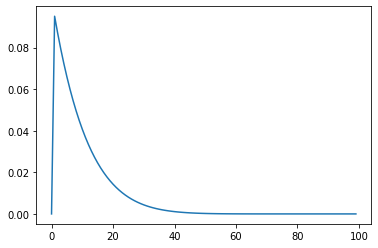

In [51]:
def pmf_cdf(lt):
    
    pmf = np.empty(grid)
    
    for i, h in enumerate(hvals):
        if(i == 0):
            pmf[i] = cdf(hvals[i], lt)
        else:
            pmf[i] = cdf(hvals[i], lt) - cdf(hvals[i-1], lt)
        
    return pmf


#test
np.sum(pmf_cdf(0.01))

pmf_cdf(0.01)
plt.plot(pmf_cdf(0.01))
    
np.sum(np.round(pmf_cdf(0.01), 19))
    

In [52]:
#gerando as pmfs

#probability mass function
pmf = np.empty((grid,grid))


for t, θt in enumerate(hvals):
    pmf[t,:] = pmf_cdf(θt)
    
#precisamos de uma pmf para quando temos lkt e queremos saber θk,t+1
#chamaremos de pmf2
pmf2 = np.empty((grid, grid))

for i in range(len(hvals)):
    for j in range(len(hvals)):
        pmf2[i, j] = np.sum(pmf[i, :] * pmf[:, j])


Arrays dos valores de continuação dos jogadores

In [53]:
#continuation values
#period, θkt, ℓkt, ℓmt
s_W = np.zeros((T, grid, grid, grid))
j_W = np.copy(s_W)


#optimal payments
#period, θkt, ℓmt, outputs
Pst_array = np.zeros((T, grid, grid, 6))
Pjt_array = np.copy(Pst_array)

In [54]:
#populating the last period with the liquidation values
s_W[(T-1), ...] = s_L(T)
j_W[(T-1), ...] = j_L(T)

Funções para calcular os valores de continuação dos jogadores

In [55]:
#função para mapear os valores das habilidades aos arrays
@njit
def find(h):
    
    return np.searchsorted(hvals, h)

find(hvals[7])
type(find(hvals[7]))

find(hvals)

#checando se temos valores repetidos
count = np.bincount(find(hvals))
np.where(count > 1)

7

int

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

(array([], dtype=int64),)

In [56]:
#array to tell us the size of the pie on next period
#period, θk,t+1
U = np.zeros((T, grid))

U = (hvals[:,None] * V[None,:] - C).T


#test
U[1,0] == hvals[0] * V[1] - Ct(1)


U[2,5] == hvals[5] * V[2] - Ct(2)

True

True

In [57]:
#função cutoff

@njit
def cutoff_m(t, Pkt, hkt, lmt, m_W):
    
    cmt = find(lmt)
    
    while(Pkt > m_W[t, cmt, cmt, find(hkt)] and hvals[cmt] < hhigh):
        cmt += 1
            
    #returns the index of the cutoff
    return max(int32(cmt), find(lmt))


cutoff_m(T-1, 0.05, 0.5, 0.4, j_W)

99

In [324]:
#função payoff ótimo

#retorna a política ótima também
#possible shares of the pie
share = np.arange(0, 1.0, step = 0.01)

#falta checar de novo as dimensões
def Pkt(t, hkt, lmt, k_W, m_W, k_L):
    
    #grid of payments is the possible continuation values of the opponent
    Pkt_grid = m_W[t, find(lmt):, find(lmt), find(hkt)]

    #new grid of payments is the share of the pie tomorrow based on the hability today
#     Pkt_grid = share * U[t, find(hkt)]
    
    
    cutoffs = int32(np.empty(Pkt_grid.shape))
    
    #loop for calculating the cutoffs
    for i, Pkt in enumerate(Pkt_grid):
        cutoffs[i] = cutoff_m(t, Pkt, hkt, lmt, m_W)
    
#     breakpoint()

    #cálculo de E1####
    
    #pE1[3,6] is the third possible payment combined with the sixth hability above hkt

    pE1 = np.array(U[t, None, find(hkt):] - Pkt_grid[:, None])
    
    
    #array com as probabilidades
    #probabiilidades de k amanhã dado a habilidade verdadeira hoje
    probk = pmf[find(hkt),find(hkt):]

    #probabilidade de m amanhã, dado o lower bound hoje
    probm = pmf2[find(lmt), find(lmt):]

    #tipo de produto de kronecker do wikipedia
    #exemplo didático
    # c = np.array([[1], [2]])
    # d = np.array([[1,2], [3,4]])

    # c
    # d

    # np.outer(c,d)

    prob = np.outer(probk,probm)
    
    #multiplicando pE1 pelo array de probabilidades
    pE1 = np.dot(pE1, prob)

    #array indicador
    IE1 = np.where(m_W[t, find(lmt):, cutoffs, find(hkt)] <= Pkt_grid[:,None] , 1, 0)

    #payoff de E1
    E1 = np.multiply(pE1, IE1)
    
    #soma ao longo das colunas (axis = 1) para que cada linha tenha o payoff esperado de propor um pagamento aceitável
    E1 = np.sum(E1, axis = 1)
    
    
    # #cálculo de E2####

    pE2 = k_W[t, find(hkt):, find(hkt), cutoffs]
    
    #multiplicando pE2 pelo array de probabilidades
    pE2 = np.dot(pE2, prob)
    
    #array indicador de 
    IE2 = np.where(IE1 == 1, 0, 1)

    
    #payoff
    E2 = np.multiply(pE2, IE2)
    E2 = np.sum(E2, axis = 1)

    #matriz dos payoffs####
    matrix_payoff = E1 + E2

    payoff_reorg = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)

    pagamento = Pkt_grid[index]
    
    
    #calculating the optimal policy between liquidating, reorganizing or waiting ####
    payoff_liq = k_L(t)
    
    
    
    
    payoff_wait = np.sum(np.multiply(pmf[find(hkt), find(hkt):], k_W[t, find(hkt):, find(hkt), find(lmt)]))
    
    
    
#     #avoiding numerical precision issues when comparing payoffs
#     if(np.allclose(payoff_wait, payoff_reorg, atol = 1e-15)):
#         #if the difference between waiting and reorganization payoff is small, then we use waiting payoff
#         payoff_max = np.max((payoff_liq, payoff_liq, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_liq, payoff_reorg))
#     else:
#         payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))

    
    
    payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
    policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))
                         
    #retorna o payoff de esperar também para facilitar a verificação do código
    return pagamento, cutoffs[index], payoff_reorg, payoff_wait, payoff_max, policy
        

t, hkt, lmt, k_W, m_W, k_L = T-1, 0.5, 0.6, s_W, j_W, s_L
# share * U[t, find(hkt)]

Pkt(t, hkt, lmt, k_W, m_W, k_L)




(0.0, 59, 0.20332358160221173, 0.19392999999999996, 0.20338, 0)

In [325]:
def Pst(t, θst, ℓjt):
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L)


def Pjt(t, θjt, ℓst):
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L)

In [326]:
#populando as matrizes para continuar os testes

for h in hvals:
    for l in hvals:
            Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
            Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)

In [327]:
#checando se populou ok
t, h, l = T-1, 0.5, 0.5
Pst_array[t, find(h), find(l),:] == Pst(t, h, l)

array([ True,  True,  True,  True,  True,  True])

In [328]:
#função da proposta ótima


def propose(t, hkt, lkt, lmt, Pkt_array):
    #apenas busca o valor de Pkt
    
    payoff_max, policy = Pkt_array[t, find(hkt), find(lmt)][-2:]
    
    return payoff_max, policy

#test


t, hkt, lkt, lmt, Pkt_array = T-1, 0.5, 0.01, 0.5, Pst_array

Pst_array[t, find(hkt), find(lmt), :] = Pkt(t, hkt, lmt, k_W, m_W, k_L)

propose(t, hkt, lkt, lmt, Pkt_array)


(0.20338, 0.0)

In [329]:
#tentando um negócio com np.where
#procura a primeira entrada do vetor de pagamentos do adversário onde a policy (última entrada) é igual a 1

np.array(np.where(Pst_array[T-1, :, find(0.5), -1] == 2.0))
#então ele diz que a menor habilidade é a de índice 50. Certeiro



Pst_array[T-1, 49, find(0.5), -1]

Pst_array[T-1, 50, find(0.5), -1]


array([[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
        66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
        98, 99]], dtype=int64)

0.0

2.0

In [330]:
#função de threshold

def threshold_m(t, lkt, lmt, Pmt_array):
    
    #procura onde a última entrada é igual a 1, que é a policy de reorganizar a firma
    threshold_vector = np.array(np.where(Pmt_array[t, :, find(lkt), -1] == 2.0))
    
    if(threshold_vector.size == 0):
        #threshold does not exist
        ts = hhigh #will update lower bound to 1 just to accelerate the calculations
        probm_liq = 1.0
        
    else:
        ts = hvals[np.min(threshold_vector)]
    
        #probability that m will propose liquidation next period
        if(lmt >= ts):
            probm_liq = 0.0
        else:
            probm_liq = cdf(ts,lmt)
        
    #returns the reorganization threshold and the probability that m will propose liquidation in t
    return ts, probm_liq
    
    
 
t, lkt,lmt, Pmt_array = T-1, 0.5,0.51, Pst_array

Pmt_array[t, :, find(lkt), -1]

threshold_m(t, lkt,lmt,  Pmt_array)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

(0.51, 0.0)

In [331]:
#payoff esperado de responder a uma proposta de reorganização

def respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W):
    ts, probm_liq = threshold_m(t, lkt, lmt, Pmt_array)
    
    lmt = max(ts, lmt)
    
    
    #the possible values of payment given by the opponent
    Pmt_grid = Pmt_array[t, find(lmt):, find(lkt), 0]
    cutoffs = Pmt_array[t, find(lmt):, find(lkt), 1]
    cutoffs = int32(cutoffs)


    #A1### 
    
    #payoff quando receber pagamento é melhor respota
    pA1 = Pmt_grid

    #ponderação pelas probabilidades
    probk = pmf[find(hkt), find(hkt): ]
    probm = pmf[find(lmt), find(lmt):]


    #primeiro vamos ver a função indicadora
    IA1 = np.where(k_W[t, find(hkt):, cutoffs, np.arange(find(lmt), grid, step = 1)].T <= Pmt_grid, 1, 0)

    #IA1 tem S linhas e J colunas

    #queremos uma matriz de probabiidades com a mesma dimensão
    prob = np.outer(probk, probm)

    np.multiply(pA1, prob) == np.multiply(pA1[None, :], prob)

    pA1 = np.multiply(pA1.T, prob)

    A1 = np.multiply(pA1, IA1)

    #A2####

    IA2 = np.where(IA1 == 1, 0, 1)

    pA2 = k_W[t, find(hkt):, cutoffs, np.arange(find(lmt), grid, step = 1)].T

    pA2 = np.multiply(pA2, prob)

    A2 = np.multiply(pA2, IA2)

    payoff = A1 + A2
    payoff = np.sum(payoff)

    #returns the expected value of answering a reorganization proposal and the probability of liquidation
    return payoff * (1-probm_liq), probm_liq


t, hkt, lkt, lmt, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, Pst_array, s_W


respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)

Pjt(t, 0.48, lkt)


(0.15896795312038225, 0.18028178662206829)

(0.19393, 49, 0.001159620096762585, 0.0, 0.001159620096762585, 2)

In [332]:
#payoff esperado de responder a uma proposta de liquidação

def respond_liq(t, hkt, lkt, lmt, k_L, m_L):
    
    #reorganiza pagando o valor de liquidação do oponente
    payoff_reorg = np.dot(pmf[find(hkt), find(hkt):], U[t, find(hkt):] - m_L(t))
    
    payoff_liq = k_L(t)
    
    return max(payoff_liq, payoff_reorg)

t, hkt, lkt, lmt, k_L, m_L = T-1, 0.5, 0.5, 0.5, s_L, j_L

respond_liq(t, hkt, lkt, lmt, k_L, m_L)
np.dot(pmf[find(hkt), find(hkt):], U[t, find(hkt):] - m_L(t))

0.20338

0.2033235816022117

In [333]:
#payoff esperado de responder
def respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L):
    
    payoff_rreorg, probm_liq = respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)
    
    return payoff_rreorg + probm_liq * respond_liq(t, hkt, lkt, lmt, k_L, m_L)
    
t, hkt, lkt, lmt, k_L, m_L, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, s_L, j_L, Pst_array, j_W

respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L)


0.03666570976319625

In [334]:
#funções de s baseado nas funções genéricas
def Pst(t, θst, ℓjt):
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L)

def s_propose(t, θst, ℓst, ℓjt):
    return propose(t, θst, ℓst, ℓjt, Pst_array)

def threshold_j(t, ℓst, ℓjt):
    return threshold_m(t, ℓst, ℓjt, Pjt_array)

def s_respond_reorg(t, θst, ℓst, ℓjt):
    return respond_reorg(t, θst, ℓst, ℓjt, Pjt_array, s_W)

def s_respond_liq(t, θst, ℓst, ℓjt):
    return respond_liq(t, θst, ℓst, ℓjt, s_L, j_L)
    
def s_respond(t, θst, ℓst, ℓjt):
    return respond(t, θst, ℓst, ℓjt, Pjt_array, s_W, s_L, j_L)


In [335]:
#funções de j baseado nas funções genéricas
def Pjt(t, θjt, ℓst):
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L)

def j_propose(t, θjt, ℓjt, ℓst):
    return propose(t, θjt, ℓjt, ℓst, Pjt_array)

def threshold_s(t, ℓjt, ℓst):
    return threshold_m(t, ℓjt, ℓst, Pst_array)

def j_respond_reorg(t, θjt, ℓjt, ℓst):
    return respond_reorg(t, θjt, ℓjt, ℓst, Pst_array, j_W)

def j_respond_liq(t, θjt, ℓjt, ℓst):
    return respond_liq(t, θjt, ℓjt, ℓst, j_L, s_L)
    
def j_respond(t, θjt, ℓjt, ℓst):
    return respond(t, θjt, ℓjt, ℓst, Pjt_array, s_W, s_L, j_L)

### Populando as matrizes do jogo

##### 1,2,3 Testando

In [336]:
t = (T-1)


start = time.process_time()

#populando as matrizes para continuar os testes

for h in hvals:
    for l in hvals:
            Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
            Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)
            

duração = time.process_time() - start



print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para popular o período 2 : 10.484375


In [337]:
#testando funções
t, hkt, lkt, lmt = T-1, 0.6, 0.4, 0.5



In [338]:
s_propose(t, hkt, lkt, lmt)


threshold_j(t, ℓkt, ℓmt)
np.where(Pjt_array[t, :, find(lkt), -1] == 2)
#ok
print('respond_reorg')
s_respond_reorg(t, hkt, lkt, lmt)

#ok, e nesse caso s prefere liquidar a firma mesmo
s_respond_liq(t, hkt, lkt, lmt)
s_L(t)


#ok
s_respond(t, hkt, lkt, lmt)


(0.24449766514018909, 2.0)

(0.48000000000000004, 0.0)

(array([47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
        98, 99], dtype=int64),)

respond_reorg


(0.19393000000000002, 0.0)

0.2444976651401891

0.20338

0.19393000000000002

In [339]:
j_propose(t, hkt, lkt, lmt)


#o threshold de ambos é para dar igual mesmo?
threshold_s(t, ℓkt, ℓmt)
np.where(Pst_array[t, :, find(lkt), -1] == 2)
#ok
print('respond_reorg')
j_respond_reorg(t, hkt, lkt, lmt)

#ok, e nesse caso s prefere liquidar a firma mesmo
j_respond_liq(t, hkt, lkt, lmt)
j_L(t)


#ok
j_respond(t, hkt, lkt, lmt)

(0.050567665140189115, 2.0)

(0.51, 0.18028178662206829)

(array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int64),)

respond_reorg


(0.0, 0.18028178662206829)

0.04111766514018911

0.0

0.19393000000000002

#### Populando todos os períodos

In [340]:


for t in range(T-1, 0, -1):

    start = time.process_time()

    #populando as matrizes para continuar os testes

    for h in hvals:
        for l in hvals:
                Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
                Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)
    print("tempo total para preparar o terreno do período", t, ":", time.process_time() - start)
    
    
    
    for i, hk in enumerate(hvals):
        for j, lk in enumerate(hvals):
            for k, lm in enumerate(hvals):
                s_W[(t-1), i, j, k] = λj * s_respond(t, hk, lk, lm) + (1-λj) * s_propose(t, hk, lk, lm)[0]
                j_W[(t-1), i, j, k] = λj * j_propose(t, hk, lk, lm)[0] + (1-λj) * j_respond(t, hk, lk, lm)


    duração = time.process_time() - start



    print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para preparar o terreno do período 2 : 10.625
tempo total para popular o período 2 : 269.90625
tempo total para preparar o terreno do período 1 : 11.203125
tempo total para popular o período 1 : 284.90625


In [341]:
#preparando o terreno no período 0 
t = 0

for h in hvals:
        for l in hvals:
                Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
                Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)

In [342]:
#testando funções
t, hkt, lkt, lmt = 0, 0.6, 0.4, 0.5

Pst(t, hkt, lmt)
Pjt(t, hkt, lmt)

(0.24235484794329432,
 49,
 0.3878122021650365,
 0.38781220216503637,
 0.3878122021650365,
 2)

(0.331632671687359,
 55,
 0.2996661642233789,
 0.29791859131998555,
 0.2996661642233789,
 2)

Salvando os dados

In [343]:
import os.path
date = '19_10'

np.save(os.path.join('Ws_array_'+date), s_W)
np.save(os.path.join('Wj_array_'+date), j_W)
np.save(os.path.join('Pst_array_'+date), Pst_array)
np.save(os.path.join('Pjt_array_'+date), Pjt_array)


Carregando os dados

In [ ]:
#dia 17_10 foi o último dia com dados errados, ρ = 0.9xxx. Antes de corrigir o threshold
#dia 19_10 foi quando consertei o threshold, ρ = 0.5

# import os.path
# date = '17_10'

# s_W = np.load(os.path.join('Ws_array_'+date+'.npy'))
# j_W = np.load(os.path.join('Wj_array_'+date+'.npy'))
# Pst_array = np.load(os.path.join('Pst_array_'+date+'.npy'))
# Pjt_array = np.load(os.path.join('Pjt_array_'+date+'.npy'))


### Gráfico das funções

Gráfico das funções propose e respond

In [344]:
def graf_func(θ_vector, t, creditor,  function, ℓkt, ℓmt):
    #true hability increases while lower bounds stay at 0.5
    #t is also endogenous 
    
    fig, ax = plt.subplots()

    #size of X axis
    X = θ_vector


    #storing the function vals in t
    graf_vals = []

    for θt in θ_vector:
        function_val = function(t, θt, ℓkt, ℓmt)
        
        #for when we use the propose method, which returns a vector
        if(np.isscalar(function_val) == False):
            function_val = function_val[0]
            

        graf_vals.append(function_val)
        
        
#     label_val = repr(function)
    title_val = print(function, 'ℓkt = ', ℓkt, 'ℓmt = ', ℓmt)

    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")

    ax.set_title(title_val)

    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()

No handles with labels found to put in legend.


<function s_propose at 0x0000016B68F8BF78> ℓkt =  0.5 ℓmt =  0.5


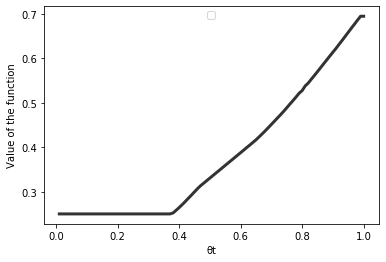

No handles with labels found to put in legend.


<function s_propose at 0x0000016B68F8BF78> ℓkt =  0.3 ℓmt =  0.9


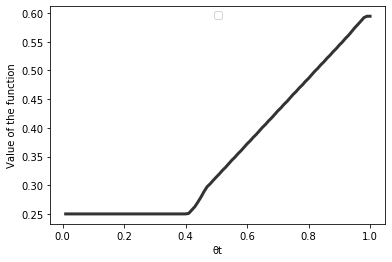

In [345]:
graf_func(hvals, 0, 's', s_propose, ℓkt = 0.5, ℓmt = 0.5)
graf_func(hvals, 0 , 's', s_propose, ℓkt = 0.3, ℓmt = 0.9)

No handles with labels found to put in legend.


<function s_respond at 0x0000016B6A06ED38> ℓkt =  0.5 ℓmt =  0.5


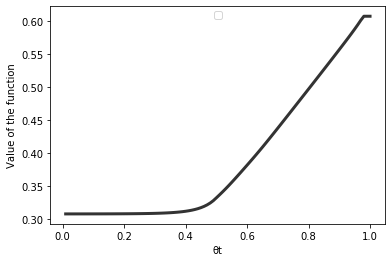

No handles with labels found to put in legend.


<function s_respond at 0x0000016B6A06ED38> ℓkt =  0.3 ℓmt =  0.9


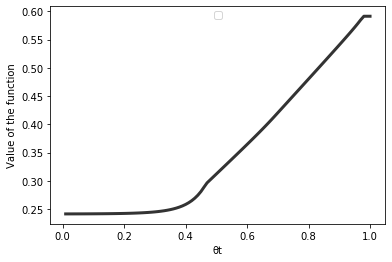

In [346]:
graf_func(hvals, 0, 's', s_respond, ℓkt = 0.5, ℓmt = 0.5)
graf_func(hvals, 0 , 's', s_respond, ℓkt = 0.3, ℓmt = 0.9)

Gráfico do valor de continuação

No handles with labels found to put in legend.


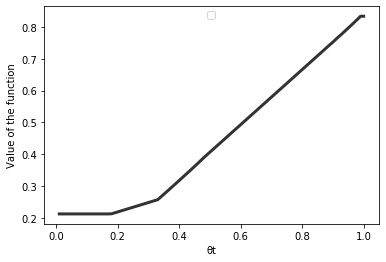

No handles with labels found to put in legend.


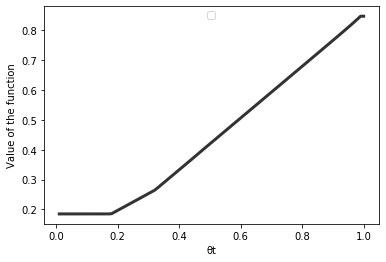

In [347]:
def graf_func_value(k_array, ℓkt, ℓmt, t):
    #t starts at t=1
    
    fig, ax = plt.subplots()

    #size of X axis
    X = hvals


    #storing the function vals in t
    graf_vals = k_array[(t-1), :, find(ℓkt), find(ℓmt)]


    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)
    
#     name = str(k_array)
#     title_val = print(name, 'ℓkt = ', ℓkt, 'ℓmt = ', ℓmt, 'period = ', t)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")


    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()
    
graf_func_value(s_W, ℓkt = 0.01, ℓmt = 0.02, t = 1)

graf_func_value(j_W, ℓkt = 0.01, ℓmt = 0.02, t = 1)

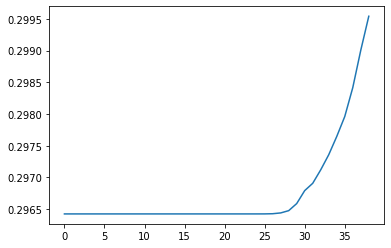

In [348]:
#checando se função valor é crescente no lower bound
t = 0
hk = 0.5
lm = 0.4


graf = np.empty(len(hvals[:find(lm)]))


for i in range(find(0.01), find(lm)):
    graf[i] = s_W[t, find(hk), find(hvals[i]), find(lm)]
    
    
plt.plot(graf)

#é crescente (não estritamente)

Gráfico das propostas ótimas

In [349]:

def graf_proposal(function, function_name, t, xlabel, ylabel):
    

    grid_graf = len(hvals)

    graf = np.empty((grid_graf, grid_graf))

    for i, θs in enumerate(hvals):
        for j, lj in enumerate(hvals):
            graf[i,j] = function(t, θs, θs, lj)[1]


    fig, ax = plt.subplots()

    cs1 = ax.contourf(hvals, hvals, graf.T, alpha=0.75)
    # ctr1 = ax.contour(hvals, lj_vals, graf1.T)
    # plt.clabel(ctr1, inline=1, fontsize=13)
    plt.colorbar(cs1, ax = ax)

    ax.set_title('Function ' + function_name +   ' in period ' + str(t) )
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    ax.ticklabel_format(useOffset=False)


    plt.show()

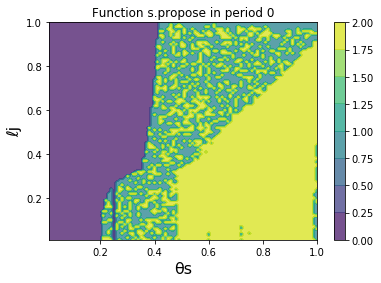

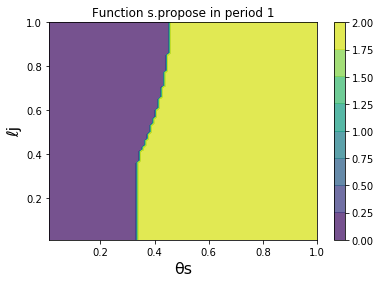

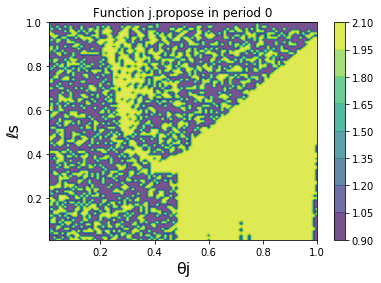

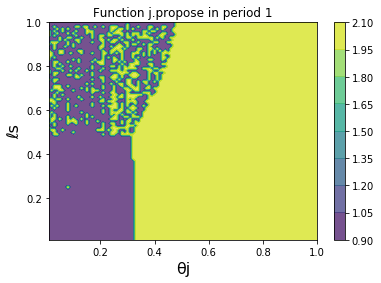

In [350]:
graf_proposal(s_propose,'s.propose', 0, 'θs', 'ℓj')

graf_proposal(s_propose,'s.propose', 1, 'θs', 'ℓj')

graf_proposal(j_propose, 'j.propose', 0, 'θj', 'ℓs')
graf_proposal(j_propose, 'j.propose', 1, 'θj', 'ℓs')

#### Checando função propose nos locais onde ela está estranha

I) Analisando s_propose em t = 0



1) Checando a linha verde quando hk = 0.6 e lj varia de 0.01 até pouco mais de 0.3

Conclusão: erros de aproximação 

In [297]:
#hk fixa e lm variando
t = 0
lm = 0.01
hk = 0.61

for i in range(find(0.01), find(0.3)):
    i, Pst(t, hk, hvals[i])[-1], Pst(t, hk, hvals[i])[2] - Pst(t, hk, hvals[i] )[3]

(0, 1, 0.0)

(1, 1, -1.1102230246251565e-16)

(2, 1, 0.0)

(3, 1, 0.0)

(4, 1, 0.0)

(5, 1, 0.0)

(6, 1, -2.220446049250313e-16)

(7, 1, 0.0)

(8, 1, 0.0)

(9, 1, 0.0)

(10, 1, 1.1102230246251565e-16)

(11, 1, -1.1102230246251565e-16)

(12, 1, 2.220446049250313e-16)

(13, 1, 1.1102230246251565e-16)

(14, 1, -1.1102230246251565e-16)

(15, 1, -1.1102230246251565e-16)

(16, 1, -1.1102230246251565e-16)

(17, 1, 0.0)

(18, 1, -1.1102230246251565e-16)

(19, 1, -5.551115123125783e-17)

(20, 1, 0.0)

(21, 1, -5.551115123125783e-17)

(22, 1, -1.1102230246251565e-16)

(23, 1, -5.551115123125783e-17)

(24, 1, 0.0)

(25, 1, 0.0)

(26, 1, 0.0)

(27, 2, 0.003220300866059178)

(28, 2, 0.017739863650548915)

In [291]:
#hk fixa e lm variando
t = 0
lm = 0.01
hk = 0.61

for i in range(find(0.01), find(0.3)):
    (Pst(t, hk, hvals[i])[2] - Pst(t, hk, hvals[i])[3])/Pst(t, hk, hvals[i])[3], Pst(t, hk, hvals[i] )[-1], i

(0.0, 1, 0)

(-2.0783570425987492e-16, 1, 1)

(0.0, 1, 2)

(0.0, 1, 3)

(0.0, 1, 4)

(0.0, 1, 5)

(-4.187733750008862e-16, 1, 6)

(0.0, 1, 7)

(0.0, 1, 8)

(0.0, 1, 9)

(2.1148737032412373e-16, 1, 10)

(-2.1219642760766872e-16, 1, 11)

(4.260045492343901e-16, 1, 12)

(2.139202646222236e-16, 1, 13)

(-2.1496863374125984e-16, 1, 14)

(-2.161691546498906e-16, 1, 15)

(-2.175479714760336e-16, 1, 16)

(0.0, 1, 17)

(-2.2097371945671839e-16, 1, 18)

(-1.115531233867755e-16, 1, 19)

(0.0, 1, 20)

(-1.1425260398544183e-16, 1, 21)

(-2.3193519273331775e-16, 1, 22)

(-1.1800079518390031e-16, 1, 23)

(0.0, 1, 24)

(0.0, 1, 25)

(0.0, 1, 26)

(0.007602125488697706, 2, 27)

(0.04353835043704093, 2, 28)

In [293]:
2.2097371945671839e-16 <= 1e-15

True

2) Quando lm está em 0.6 e hk varia de 0.35 a 0.7. Conclusão: diferenças na 17 casa decimal fazem proposta sair diferente

In [198]:
#hk variando e lm fixa
t = 0
lm = 0.6

low = 0.35
high = 0.7

for i in range(find(low), find(high)):
    Pst(0, hvals[i], lm )[2] - Pst(0, hvals[i], lm )[3], Pst(0, hvals[i], lm )[-1], i

(0.0, 0, 34)

(0.0, 0, 35)

(5.551115123125783e-17, 0, 36)

(-2.7755575615628914e-17, 0, 37)

(8.326672684688674e-17, 0, 38)

(-2.7755575615628914e-17, 0, 39)

(5.551115123125783e-17, 1, 40)

(0.0, 1, 41)

(0.0, 1, 42)

(0.0, 1, 43)

(0.0, 1, 44)

(1.1102230246251565e-16, 1, 45)

(0.0, 1, 46)

(-5.551115123125783e-17, 1, 47)

(5.551115123125783e-17, 1, 48)

(0.0, 1, 49)

(-5.551115123125783e-17, 1, 50)

(1.1102230246251565e-16, 1, 51)

(0.0, 1, 52)

(0.0, 1, 53)

(0.0, 1, 54)

(0.0, 1, 55)

(5.551115123125783e-17, 1, 56)

(1.1102230246251565e-16, 1, 57)

(0.0, 1, 58)

(5.551115123125783e-17, 1, 59)

(-5.551115123125783e-17, 1, 60)

(-5.551115123125783e-17, 1, 61)

(0.0, 1, 62)

(0.0, 1, 63)

(0.0, 1, 64)

(5.551115123125783e-17, 1, 65)

(0.0, 1, 66)

(0.0, 1, 67)

(0.0, 1, 68)

II) Analisado j_propose em t = 0

1) Checando quando lm = 0.01 e hk varia entre 0.01 e 0.4. Conclusão: diferença na 17 casa decimal faz proposta ficar errada

In [180]:
#hk variando e lm fixa
t = 0
lm = 0.01

low = 0.01
high = 0.4

for i in range(find(low), find(high)):
    Pjt(0, hvals[i], lm )[2] - Pjt(0, hvals[i], lm )[3], Pjt(0, hvals[i], lm )[-1], i

(-2.7755575615628914e-17, 1, 0)

(0.0, 1, 1)

(0.0, 1, 2)

(-2.7755575615628914e-17, 1, 3)

(2.7755575615628914e-17, 2, 4)

(-5.551115123125783e-17, 1, 5)

(2.7755575615628914e-17, 2, 6)

(-5.551115123125783e-17, 1, 7)

(2.7755575615628914e-17, 2, 8)

(-5.551115123125783e-17, 1, 9)

(2.7755575615628914e-17, 2, 10)

(0.0, 1, 11)

(-2.7755575615628914e-17, 1, 12)

(-2.7755575615628914e-17, 1, 13)

(2.7755575615628914e-17, 2, 14)

(2.7755575615628914e-17, 2, 15)

(8.326672684688674e-17, 2, 16)

(5.551115123125783e-17, 2, 17)

(2.7755575615628914e-17, 2, 18)

(2.7755575615628914e-17, 2, 19)

(0.0, 1, 20)

(2.7755575615628914e-17, 2, 21)

(0.0, 1, 22)

(0.0, 1, 23)

(2.7755575615628914e-17, 2, 24)

(-2.7755575615628914e-17, 1, 25)

(2.7755575615628914e-17, 2, 26)

(0.0, 1, 27)

(2.7755575615628914e-17, 2, 28)

(-2.7755575615628914e-17, 1, 29)

(0.0, 1, 30)

(-2.7755575615628914e-17, 1, 31)

(0.0, 1, 32)

(5.551115123125783e-17, 2, 33)

(-8.326672684688674e-17, 1, 34)

(2.7755575615628914e-17, 2, 35)

(0.002524245040856826, 2, 36)

(5.551115123125783e-17, 2, 37)

(0.009708327897446634, 2, 38)

Conclusão geral: erros na 17 casa decimal provocaram erros tanto em s_propose quando em j_propose. Além disso, as duas funções têm um padrão estranho quando hk = 0.61 e lm varia entre 0.01 e 0.4.

Assim, acho que o problema é na PMF.

EDIT: acho que é um erro de arredondamento também, vide: https://stackoverflow.com/questions/8792430/precision-in-numpy-issues-while-comparing-numbers

2) Analisando j_propose em t = 1, no intervalo entre hk = 0.01 e 0.4 enquanto lm = 0.19

In [311]:
#hk variando e lm fixa
t = 1
lm = 0.19

low = 0.01
high = 0.4

for i in range(find(low), find(high)):
    Pjt(t, hvals[i], lm )[2] - Pjt(t, hvals[i], lm )[3], np.allclose(Pjt(t, hvals[i], lm )[2],Pjt(t, hvals[i], lm )[3], rtol = 1e-5),Pjt(t, hvals[i], lm )[-1], i

(0.0, True, 2, 0)

(-2.7755575615628914e-17, True, 2, 1)

(2.7755575615628914e-17, True, 2, 2)

(-2.7755575615628914e-17, True, 2, 3)

(0.0, True, 2, 4)

(-2.7755575615628914e-17, True, 2, 5)

(2.7755575615628914e-17, True, 2, 6)

(2.7755575615628914e-17, True, 2, 7)

(2.7755575615628914e-17, True, 2, 8)

(0.0, True, 2, 9)

(2.7755575615628914e-17, True, 2, 10)

(0.0, True, 2, 11)

(0.0, True, 2, 12)

(5.551115123125783e-17, True, 2, 13)

(2.7755575615628914e-17, True, 2, 14)

(0.0, True, 2, 15)

(0.0, True, 2, 16)

(0.0, True, 2, 17)

(0.0, True, 2, 18)

(2.7755575615628914e-17, True, 2, 19)

(0.0, True, 2, 20)

(5.551115123125783e-17, True, 2, 21)

(2.7755575615628914e-17, True, 2, 22)

(-2.7755575615628914e-17, True, 2, 23)

(-2.7755575615628914e-17, True, 2, 24)

(5.551115123125783e-17, True, 2, 25)

(2.7755575615628914e-17, True, 2, 26)

(0.0, True, 2, 27)

(0.0, True, 2, 28)

(2.7755575615628914e-17, True, 2, 29)

(2.7755575615628914e-17, True, 2, 30)

(2.7755575615628914e-17, True, 2, 31)

(0.0055053245168081855, False, 2, 32)

(0.012437034879982156, False, 2, 33)

(0.02253890825683702, False, 2, 34)

(0.03021851771827372, False, 2, 35)

(0.03821525072500101, False, 2, 36)

(0.046519357083279506, False, 2, 37)

(0.05191574178007438, False, 2, 38)

#### Tentando solução com allclose()

Vou refazer o último caso (j_propose variando hk) usando np.allclose()

allclose() diz **se** dois arrays são iguais dentro de uma tolerância
isclose() diz **onde** dois arrays são iguais dentro de uma tolerância

In [212]:
#hk variando e lm fixa
t = 0
lm = 0.01

low = 0.01
high = 0.4

for i in range(find(low), find(high)):
    Pjt(0, hvals[i], lm )[2] - Pjt(0, hvals[i], lm )[3], np.allclose(Pjt(0, hvals[i], lm )[2],Pjt(0, hvals[i], lm )[3], rtol = 1e-5),Pjt(0, hvals[i], lm )[-1], i

(-2.7755575615628914e-17, True, 1, 0)

(0.0, True, 1, 1)

(0.0, True, 1, 2)

(-2.7755575615628914e-17, True, 1, 3)

(2.7755575615628914e-17, True, 1, 4)

(-5.551115123125783e-17, True, 1, 5)

(2.7755575615628914e-17, True, 1, 6)

(-5.551115123125783e-17, True, 1, 7)

(2.7755575615628914e-17, True, 1, 8)

(-5.551115123125783e-17, True, 1, 9)

(2.7755575615628914e-17, True, 1, 10)

(0.0, True, 1, 11)

(-2.7755575615628914e-17, True, 1, 12)

(-2.7755575615628914e-17, True, 1, 13)

(2.7755575615628914e-17, True, 1, 14)

(2.7755575615628914e-17, True, 1, 15)

(8.326672684688674e-17, True, 1, 16)

(5.551115123125783e-17, True, 1, 17)

(2.7755575615628914e-17, True, 1, 18)

(2.7755575615628914e-17, True, 1, 19)

(0.0, True, 1, 20)

(2.7755575615628914e-17, True, 1, 21)

(0.0, True, 1, 22)

(0.0, True, 1, 23)

(2.7755575615628914e-17, True, 1, 24)

(-2.7755575615628914e-17, True, 1, 25)

(2.7755575615628914e-17, True, 1, 26)

(0.0, True, 1, 27)

(2.7755575615628914e-17, True, 1, 28)

(-2.7755575615628914e-17, True, 1, 29)

(0.0, True, 1, 30)

(-2.7755575615628914e-17, True, 1, 31)

(0.0, True, 1, 32)

(5.551115123125783e-17, True, 1, 33)

(-8.326672684688674e-17, True, 1, 34)

(2.7755575615628914e-17, True, 1, 35)

(0.002524245040856826, False, 2, 36)

(5.551115123125783e-17, True, 1, 37)

(0.009708327897446634, False, 2, 38)

In [213]:
for i in range(find(low), find(high)):
    Pjt(0, hvals[i], lm )[3], i

(0.186605154762956, 0)

(0.1834889843762526, 1)

(0.18585823941218857, 2)

(0.1799555859991388, 3)

(0.18683994328703413, 4)

(0.18015537288494368, 5)

(0.1821291230611339, 6)

(0.185897212010058, 7)

(0.1961384105871803, 8)

(0.1807176537253595, 9)

(0.18090332117713898, 10)

(0.1811120361655817, 11)

(0.18134696557854496, 12)

(0.18494389282679294, 13)

(0.18191060495846095, 14)

(0.18629749897103204, 15)

(0.18263065886365693, 16)

(0.18306397600609955, 17)

(0.19399587615772362, 18)

(0.18411510295574485, 19)

(0.21579661248689075, 20)

(0.2188547303978451, 21)

(0.22200983934018453, 22)

(0.2252774470659398, 23)

(0.19669084122102445, 24)

(0.189596740243235, 25)

(0.19103659434309844, 26)

(0.23373177953765964, 27)

(0.20484579056344893, 28)

(0.19682845969970486, 29)

(0.19939685300104804, 30)

(0.24315484080777303, 31)

(0.2771131000597219, 32)

(0.26934198834150846, 33)

(0.2120739112039278, 34)

(0.2154029577296413, 35)

(0.218806338012058, 36)

(0.31956316202608626, 37)

(0.2259867342982389, 38)